In [1]:
! pip install imblearn

In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np

def get_confusion_matrix_params(y_test, y_pred, n_classes):
  cf = confusion_matrix(y_test, y_pred)
  params = []

  # We have used One-vs-Rest multiclass classification...
  for cl in range(n_classes):
    tp = cf[cl, cl]
    fp = sum(cf[:, cl]) - tp
    fn = sum(cf[cl, :]) - tp
    tn = np.sum(cf) - tp - fp - fn
    params.append([tp, fp, fn, tn])
  return params

In [4]:
from statistics import mean

def get_performance_metrics(params):
  ppv_per_class = []
  npv_per_class = []
  specificity_per_class = []
  sensitivity_per_class = []
  accuracy_per_class = []
  f1_per_class = []

  for i in range(len(params)):
    tp = params[i][0]
    fp = params[i][1]
    fn = params[i][2]
    tn = params[i][3]
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sens = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    acc = (tn + tp) / (tn + fp + fn + tp) if (tn + fp + fn + tp) != 0 else 0.
    f1 = (2 * ppv * sens) / (ppv + sens) if (ppv + sens) != 0 else 0

    ppv_per_class.append(ppv)
    npv_per_class.append(npv)
    specificity_per_class.append(spec)
    sensitivity_per_class.append(spec)
    accuracy_per_class.append(acc)
    f1_per_class.append(spec)

  return ppv_per_class, npv_per_class, specificity_per_class, sensitivity_per_class, accuracy_per_class, f1_per_class

In [5]:
def prepare_classification_results(params, original_labels):
  ppv, npv, specificity, sensitivity, accuracy, f1 = get_performance_metrics(params)
  params_grid = np.array([ppv, npv, specificity, sensitivity, accuracy, f1])
  params_grid = np.transpose(params_grid)
  params_df = pd.DataFrame(params_grid, columns=['PPV', 'NPV', 'Specificity', 'Sensitivity', 'Accuracy', 'F1-Score'])
  params_df.index = np.unique(original_labels)
  return params_df

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_output(y):
  le = LabelEncoder()
  y_trans = le.fit_transform(y)
  original_labels = le.inverse_transform(y_trans)
  y_cat = to_categorical(y_trans)
  return y_trans, y_cat, original_labels

In [7]:
from sklearn.decomposition import PCA
import numpy as np

def pca(X, n_comp):
  pca = PCA(n_components=n_comp)
  X_pca = pca.fit_transform(X)
  return X_pca

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda(X, y, n_comp):
  lda = LinearDiscriminantAnalysis(n_components=n_comp, solver='svd', shrinkage=None)
  X_lda = lda.fit_transform(X, y)
  return X_lda

In [9]:
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

# Variance Threshold -> Removes all low variance features...
def variance_threshold(X):
  var_thres = VarianceThreshold(threshold=0.1)
  var_thres.fit(X)
  return X[X.columns[var_thres.get_support(indices=True)]]
  # return X_thres

In [10]:
from sklearn.ensemble import IsolationForest
import pandas as pd

def isolation_forest(X_in, y):
  df = pd.concat([X_in, y], axis=1)
  iso_forest_with_target = IsolationForest(contamination=0.12)
  iso_forest_with_target.fit(df)
  df['outlier_with_target'] = iso_forest_with_target.predict(df)
  df_cleaned_with_target = df[df['outlier_with_target'] != -1].drop('outlier_with_target', axis=1)
  X_out = df_cleaned_with_target.drop(['GLEASON_SCORE'], axis=1)
  y_out = df_cleaned_with_target['GLEASON_SCORE']
  return X_out, y_out

In [11]:
from sklearn.feature_selection import mutual_info_classif

def info_gain_scores(X, y):
  mi_scores = mutual_info_classif(X, y)
  mi_scores = pd.Series(mi_scores)
  mi_scores.index = X.columns
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

In [12]:
def select_info_gain_features(mi_scores, n_features, X):
  selected_indices = mi_scores.index[:n_features]
  X_selected = X[selected_indices]
  return X_selected

In [13]:
def select_info_gain_features_direct(feature_indices, n_features, X):
  selected_indices = feature_indices[:n_features]
  X_selected = X[selected_indices]
  return X_selected

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def run_classifier(model, X_train_main, y_train_main, class_count):
  y_act, y_categorical, original_labels = encode_output(y_train_main)
  params = []

  # We use Stratified K-Fold to maintain the same class distribution in each fold as in the entire dataset...
  sk_fold = StratifiedKFold(n_splits=10)
  for train_index, test_index in sk_fold.split(X_train_main, y_train_main):
    X_train, X_test = X_train_main.iloc[train_index], X_train_main.iloc[test_index]
    y_train, y_test = y_act[train_index], y_act[test_index]

    # Training and testing the model...
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # We select any model after training in any cross-validation fold to score the left out test set...
    any_model = model

    # We get the confusion matrix parameters (TN, FP, FN, TP) for each cross-validation fold
    # and add them for micro averaging after the 10 folds...
    param_cf = get_confusion_matrix_params(y_test, y_pred, n_classes=class_count)

    if len(params) == 0:
      params = param_cf
    else:
      params = np.array(params) + np.array(param_cf)

  params_df = prepare_classification_results(params, original_labels)
  return params_df, any_model

In [15]:
from sklearn.model_selection import train_test_split

def process(model, X, y, feature_priority_list, max_features, class_count, is_ncl=True):
  n_features = np.arange(1, max_features + 1)
  params_df_list = []
  params_df_out_list = []
  feature_count_accuracy_list = []

  # We select 1 to 250 selected features and run classification...
  for feature_count in n_features:
    print('/-------- Feature Count: ', feature_count, '--------/')
    # Feature selection which selects the top n features where n varies from 1 to 250
    # according to the feature_count loop variable...
    X_selected = select_info_gain_features_direct(feature_priority_list, n_features=feature_count, X=X)

    # We perform 10-fold cross-validation...
    # The final score is calculated on a random testing set using the model trained in any fold of cross-validation...
    X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X_selected, y, test_size=0.30, stratify=y)
    params_df, model_trained = run_classifier(model, X_selected, y, class_count)
    params_df_list.append(params_df)

    # Getting classification parameters for the random test set...
    y_l1, y_categorical_l2, original_labels_l3 = encode_output(y_test_main)
    y_pred_out = model_trained.predict(X_test_main)
    param_cf_out = get_confusion_matrix_params(y_l1, y_pred_out, n_classes=class_count)
    params_df_out = prepare_classification_results(param_cf_out, original_labels_l3)
    params_df_out_list.append(params_df_out)
    feature_count_accuracy = model_trained.score(X_test_main, y_l1)
    feature_count_accuracy_list.append(feature_count_accuracy)

    print(feature_count_accuracy)

  return params_df_list, feature_count_accuracy_list, params_df_out_list

In [16]:
import matplotlib.pyplot as plt

def plot_lda(X, y, title, n_components, ticks):
  # Performing LDA with 'n_components' components which is 1 less than the number of classes...
  X_lda = lda(X, y, n_components)
  y_l1, y_categorical_l2, original_labels_l3 = encode_output(y)

  # Plot LDA...
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_l1)
  plt.colorbar(scatter, label='Target Class', ticks=ticks)
  plt.xlabel('LDA 1')
  plt.ylabel('LDA 2')
  plt.title(title)
  plt.show()

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.svm import SVC

def build_roc_auc(X, y, classes, title):
  y_bin = label_binarize(y, classes=classes)
  X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)
  # Passing the SVC classifier...
  classifier = OneVsRestClassifier(SVC())
  classifier.fit(X_train, y_train)
  y_score = classifier.decision_function(X_test)

  # Building ROC curve and AUC for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = y_bin.shape[1]

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(8, 6))
  colors = cycle(['blue', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow'])

  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.show()

In [18]:
def plot_class_distribution(unique_values, counts):
  plt.bar(unique_values, counts)
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

def driver(model, X, y, features, max_features, lda_ticks, is_ncl=False):
  classes = y.unique()
  class_count = y.unique().size

  X_backup = X
  y_backup = y

  # Start the data processing and classification...
  params_df_list, feature_count_accuracy_list, params_df_out_list = process(model, X, y, features, max_features, class_count, is_ncl)

  # We show the plot of number of features vs Accuracy...
  # It is seen that accuracy increases with increasing number of features but becomes stagnant after ~150-200 selected features...
  x = np.arange(1, max_features + 1)
  y = feature_count_accuracy_list
  plt.plot(x, y)
  plt.xlabel('Number of Features')
  plt.ylabel('Accuracy')
  plt.show()

  # We find the maximum accuracy to be nearly 0.975 to 1.0...
  # This was tested on the left out test set after 10-fold cross-validation...
  print('Maximum Accuracy:', np.max(feature_count_accuracy_list))

  # The maximum accuracy achieved above nearly 150 to 200 features after which it varies little...
  max_accuracy_feature_count = np.argmax(feature_count_accuracy_list) + 1
  print('Maximum Accuracy is achieved with', max_accuracy_feature_count, 'features')

  # These are the classification parameters after testing the model trained from any fold of the 10-folds for each class
  # using 'max_accuracy_feature_count' features, since we got the highest accuracy with 'max_accuracy_feature_count' features,
  # on the left out test set...
  print('\nClassification Parameters after Cross-Validation:')
  print(params_df_out_list[max_accuracy_feature_count - 1])

In [20]:
import pandas as pd

def import_dataset():
  df = pd.read_pickle('df_merged_gs_updated.pkl')
  X = df.drop(['PATIENT_ID', 'GLEASON_PATTERN_PRIMARY', 'GLEASON_PATTERN_SECONDARY', 'GLEASON_SCORE'], axis=1)
  y = df['GLEASON_SCORE']
  return X, y, df

In [21]:
import pickle
from sklearn.preprocessing import scale

# Load Dataset and classify with Gleason Score...
X_main, y_main, df = import_dataset()

# Backup...
X = X_main
y = y_main

# Scaling the features...
cols = X.columns
X_np = scale(X)
X = pd.DataFrame(X_np)
X.columns = cols

In [49]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule, TomekLinks

# Applying SMOTE for oversampling...
smote = SMOTE(k_neighbors=3)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

# Results do not change much with undersampling after SMOTE...
# tl = TomekLinks()
# X_resampled, y_resampled = tl.fit_resample(X_resampled_smote, y_resampled_smote)

# ncl = NeighbourhoodCleaningRule(sampling_strategy='auto')
# X_resampled, y_resampled = ncl.fit_resample(X_resampled_smote, y_resampled_smote)

In [61]:
# Increase in number of samples after resampling...
X_resampled_smote.shape

(725, 60483)

In [50]:
# Removing low variance features...
X_var = variance_threshold(X_resampled_smote)

In [51]:
# Isolation Forest - Outliers detection and removal...
X_clean, y_clean = isolation_forest(X_var, y_resampled_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [62]:
# Outliers removed...
X_clean.shape

(580, 57465)

In [52]:
# Feature selection using Information Gain...
mi_scores = info_gain_scores(X_clean, y_clean)
feature_priorities_info_gain = mi_scores.index

In [44]:
list(feature_priorities_info_gain)

Index(['ENSG00000182492.14', 'ENSG00000213916.2', 'ENSG00000183379.7',
       'ENSG00000106603.16', 'ENSG00000070526.13', 'ENSG00000233308.1',
       'ENSG00000277791.3', 'ENSG00000076382.15', 'ENSG00000185038.13',
       'ENSG00000132854.17',
       ...
       'ENSG00000274451.1', 'ENSG00000263354.1', 'ENSG00000235148.2',
       'ENSG00000266450.1', 'ENSG00000237492.1', 'ENSG00000274823.1',
       'ENSG00000170667.13', 'ENSG00000250590.4', 'ENSG00000196578.4',
       'ENSG00000186792.14'],
      dtype='object', length=57375)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

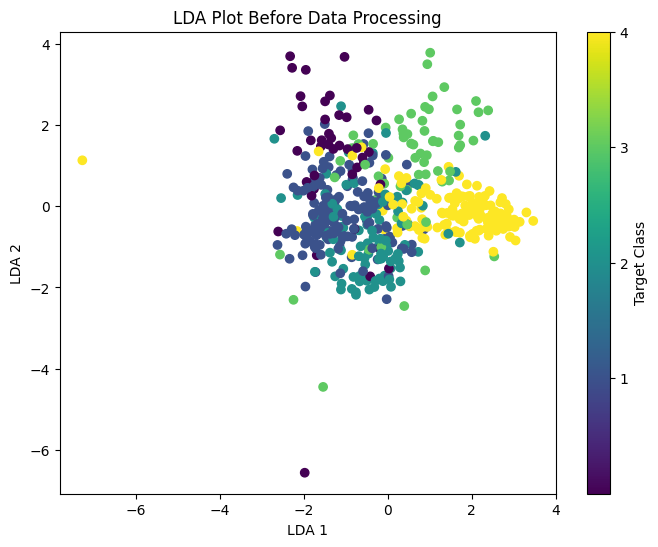

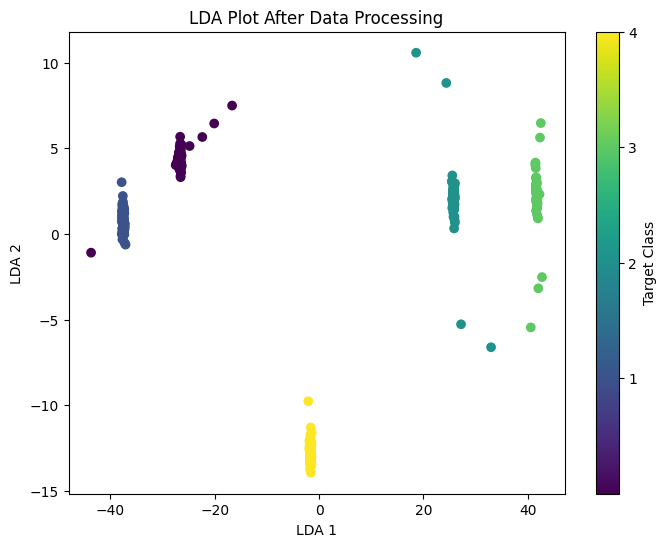


*-------- Class Distribution before Data Processing --------*
Class 1: 44 rows
Class 2: 145 rows
Class 3: 101 rows
Class 4: 63 rows
Class 5: 141 rows


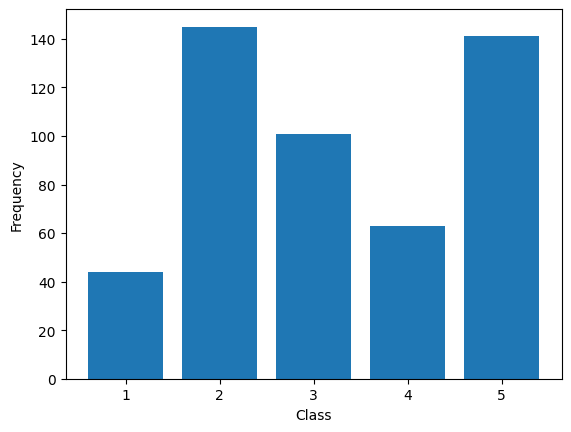


*-------- Class Distribution after Data Processing --------*
Class 1: 131 rows
Class 2: 118 rows
Class 3: 117 rows
Class 4: 121 rows
Class 5: 93 rows


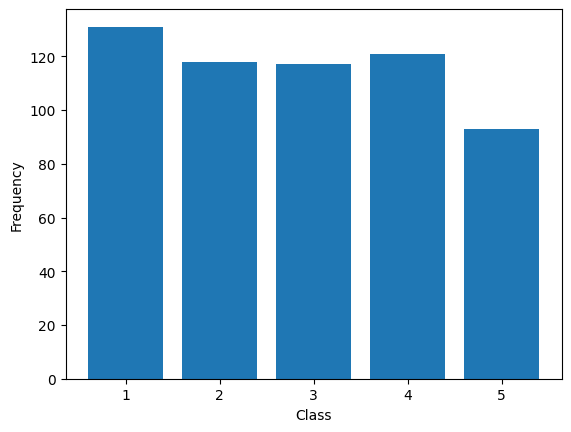

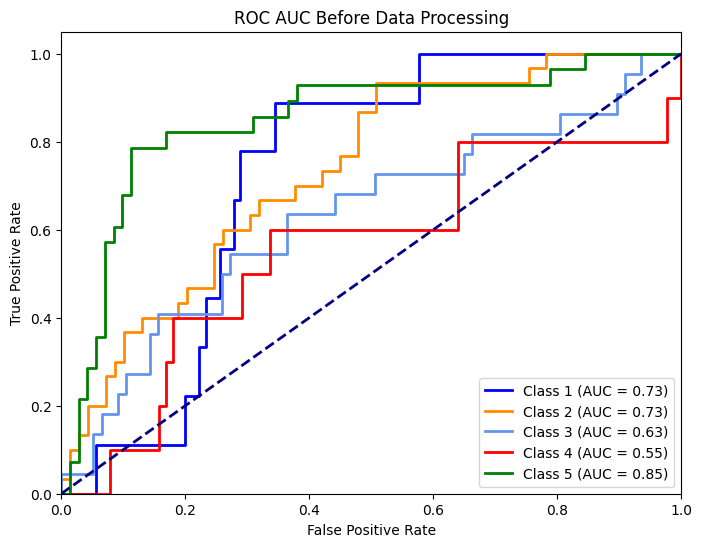

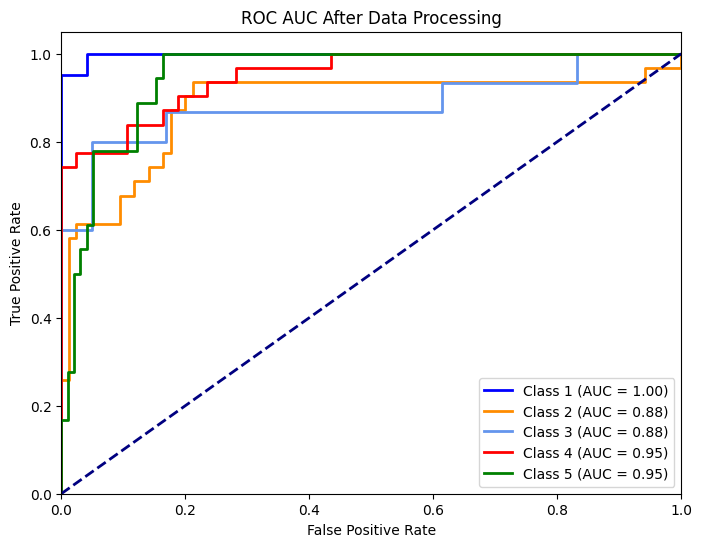

In [59]:
# Now we perform feature selection and data processing to show the LDA plot on the original dataset with
# selected features and modified samples to show good class separation...
# Since accuracy is stable at more than 0.97 after around ~150-200 selected features,
# we can choose any number of features > 150 to show LDA plot...
X_selected_post = select_info_gain_features_direct(feature_priorities_info_gain, n_features=X_clean.shape[0], X=X_clean)

# We choose LDA components as 4 since there are 5 classes in the dataset...
# Plot LDA before processing the data with all the features...
plot_lda(X_main, y_main, 'LDA Plot Before Data Processing', n_components=4, ticks=[1, 2, 3, 4, 5])

# Plot LDA after processing the data with the selected features...
plot_lda(X_selected_post, y_clean, 'LDA Plot After Data Processing', n_components=4, ticks=[1, 2, 3, 4, 5])

# Showing the unique value counts for all the classes before processing the data...
print('\n*-------- Class Distribution before Data Processing --------*')
unique_values, counts = np.unique(y_main, return_counts=True)
for value, count in zip(unique_values, counts):
  print(f"Class {value}: {count} rows")

# Plotting the unbalanced and unprocessed class distribution...
plot_class_distribution(unique_values, counts)

# Showing the unique value counts for all the classes after processing the data...
# We see that the classes are balanced now...
print('\n*-------- Class Distribution after Data Processing --------*')
unique_values_balanced, counts_balanced = np.unique(y_clean, return_counts=True)
for value, count in zip(unique_values_balanced, counts_balanced):
  print(f"Class {value}: {count} rows")

# Plotting the unbalanced and unprocessed class distribution...
plot_class_distribution(unique_values_balanced, counts_balanced)

# We now split the processed dataset into training and testing sets and pass it through the One vs Rest Classifier
# with specified classification model for random evaluation and showing the ROC curve and AUC value for each class...
# The goal is to show that class separation has been drastically improved after processing the data...

# ROC and AUC before processing the data with all the features...
build_roc_auc(X_main, y_main, [1, 2, 3, 4, 5], title='ROC AUC Before Data Processing')

# ROC and AUC after processing the Data with the selected optimal number of features...
# It is also seen here that the classes are balanced...
build_roc_auc(X_selected_post, y_clean, [1, 2, 3, 4, 5], title='ROC AUC After Data Processing')

/-------- Feature Count:  1 --------/
0.39655172413793105
/-------- Feature Count:  2 --------/
0.40804597701149425
/-------- Feature Count:  3 --------/
0.4482758620689655
/-------- Feature Count:  4 --------/
0.47126436781609193
/-------- Feature Count:  5 --------/
0.4885057471264368
/-------- Feature Count:  6 --------/
0.5517241379310345
/-------- Feature Count:  7 --------/
0.5229885057471264
/-------- Feature Count:  8 --------/
0.5057471264367817
/-------- Feature Count:  9 --------/
0.5229885057471264
/-------- Feature Count:  10 --------/
0.5804597701149425
/-------- Feature Count:  11 --------/
0.5747126436781609
/-------- Feature Count:  12 --------/
0.5459770114942529
/-------- Feature Count:  13 --------/
0.5459770114942529
/-------- Feature Count:  14 --------/
0.603448275862069
/-------- Feature Count:  15 --------/
0.5862068965517241
/-------- Feature Count:  16 --------/
0.6494252873563219
/-------- Feature Count:  17 --------/
0.6206896551724138
/-------- Feature Cou

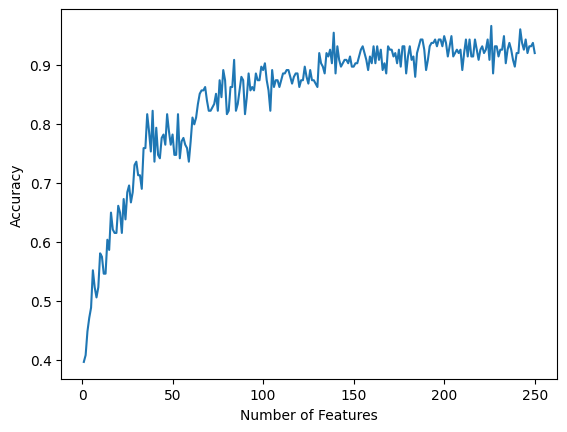

Maximum Accuracy: 0.9655172413793104
Maximum Accuracy is achieved with 226 features

Classification Parameters after Cross-Validation:
        PPV       NPV  Specificity  Sensitivity  Accuracy  F1-Score
1  0.975000  1.000000     0.992593     0.992593  0.994253  0.992593
2  0.916667  0.978261     0.978261     0.978261  0.965517  0.978261
3  1.000000  0.992857     1.000000     1.000000  0.994253  1.000000
4  1.000000  0.992806     1.000000     1.000000  0.994253  1.000000
5  0.931034  0.993103     0.986301     0.986301  0.982759  0.986301


In [55]:
driver(SVC(), X_clean, y_clean, feature_priorities_info_gain, max_features=250, lda_ticks=[1, 2, 3, 4, 5])

/-------- Feature Count:  1 --------/
0.40804597701149425
/-------- Feature Count:  2 --------/
0.39655172413793105
/-------- Feature Count:  3 --------/
0.40804597701149425
/-------- Feature Count:  4 --------/
0.367816091954023
/-------- Feature Count:  5 --------/
0.4540229885057471
/-------- Feature Count:  6 --------/
0.40229885057471265
/-------- Feature Count:  7 --------/
0.4482758620689655
/-------- Feature Count:  8 --------/
0.4885057471264368
/-------- Feature Count:  9 --------/
0.43103448275862066
/-------- Feature Count:  10 --------/
0.45977011494252873
/-------- Feature Count:  11 --------/
0.40804597701149425
/-------- Feature Count:  12 --------/
0.4827586206896552
/-------- Feature Count:  13 --------/
0.5057471264367817
/-------- Feature Count:  14 --------/
0.4540229885057471
/-------- Feature Count:  15 --------/
0.4942528735632184
/-------- Feature Count:  16 --------/
0.5114942528735632
/-------- Feature Count:  17 --------/
0.5402298850574713
/-------- Feature

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  197 --------/
0.9597701149425287
/-------- Feature Count:  198 --------/
0.9540229885057471
/-------- Feature Count:  199 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9540229885057471
/-------- Feature Count:  200 --------/
0.9367816091954023
/-------- Feature Count:  201 --------/
0.9425287356321839
/-------- Feature Count:  202 --------/
0.9425287356321839
/-------- Feature Count:  203 --------/
0.9770114942528736
/-------- Feature Count:  204 --------/
0.9540229885057471
/-------- Feature Count:  205 --------/
0.9827586206896551
/-------- Feature Count:  206 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9540229885057471
/-------- Feature Count:  207 --------/
0.9712643678160919
/-------- Feature Count:  208 --------/
0.9367816091954023
/-------- Feature Count:  209 --------/
0.9597701149425287
/-------- Feature Count:  210 --------/
0.9655172413793104
/-------- Feature Count:  211 --------/
0.9597701149425287
/-------- Feature Count:  212 --------/
0.9770114942528736
/-------- Feature Count:  213 --------/
0.9425287356321839
/-------- Feature Count:  214 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  215 --------/
0.9597701149425287
/-------- Feature Count:  216 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  217 --------/
0.9540229885057471
/-------- Feature Count:  218 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  219 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  220 --------/
0.9712643678160919
/-------- Feature Count:  221 --------/
0.9655172413793104
/-------- Feature Count:  222 --------/
0.9655172413793104
/-------- Feature Count:  223 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  224 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9827586206896551
/-------- Feature Count:  225 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9655172413793104
/-------- Feature Count:  226 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9712643678160919
/-------- Feature Count:  227 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9770114942528736
/-------- Feature Count:  228 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9712643678160919
/-------- Feature Count:  229 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9885057471264368
/-------- Feature Count:  230 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9655172413793104
/-------- Feature Count:  231 --------/
0.9540229885057471
/-------- Feature Count:  232 --------/
0.9540229885057471
/-------- Feature Count:  233 --------/
0.9712643678160919
/-------- Feature Count:  234 --------/
0.9712643678160919
/-------- Feature Count:  235 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9655172413793104
/-------- Feature Count:  236 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9597701149425287
/-------- Feature Count:  237 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9655172413793104
/-------- Feature Count:  238 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9712643678160919
/-------- Feature Count:  239 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9827586206896551
/-------- Feature Count:  240 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9540229885057471
/-------- Feature Count:  241 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9712643678160919
/-------- Feature Count:  242 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9712643678160919
/-------- Feature Count:  243 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9425287356321839
/-------- Feature Count:  244 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9770114942528736
/-------- Feature Count:  245 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9827586206896551
/-------- Feature Count:  246 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9827586206896551
/-------- Feature Count:  247 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9712643678160919
/-------- Feature Count:  248 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9770114942528736
/-------- Feature Count:  249 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9770114942528736
/-------- Feature Count:  250 --------/


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9770114942528736


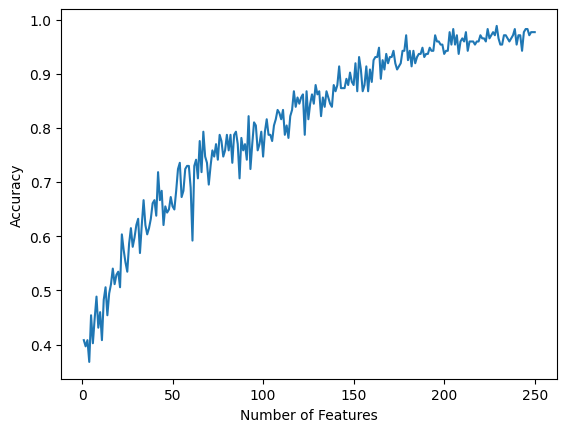

Maximum Accuracy: 0.9885057471264368
Maximum Accuracy is achieved with 229 features

Classification Parameters after Cross-Validation:
        PPV       NPV  Specificity  Sensitivity  Accuracy  F1-Score
1  0.975000  1.000000     0.992593     0.992593  0.994253  0.992593
2  1.000000  0.992806     1.000000     1.000000  0.994253  1.000000
3  0.972222  1.000000     0.992806     0.992806  0.994253  0.992806
4  1.000000  1.000000     1.000000     1.000000  1.000000  1.000000
5  1.000000  0.993197     1.000000     1.000000  0.994253  1.000000


In [56]:
driver(LogisticRegression(multi_class='ovr'), X_clean, y_clean, feature_priorities_info_gain, max_features=250, lda_ticks=[1, 2, 3, 4, 5])